## Activate Bioinfo Conda Environment

In [ ]:
# Activate conda env
conda activate bioinfo

## Installation

`mamba install bwa bctools igv samtools -y`


# Short Read Alignment

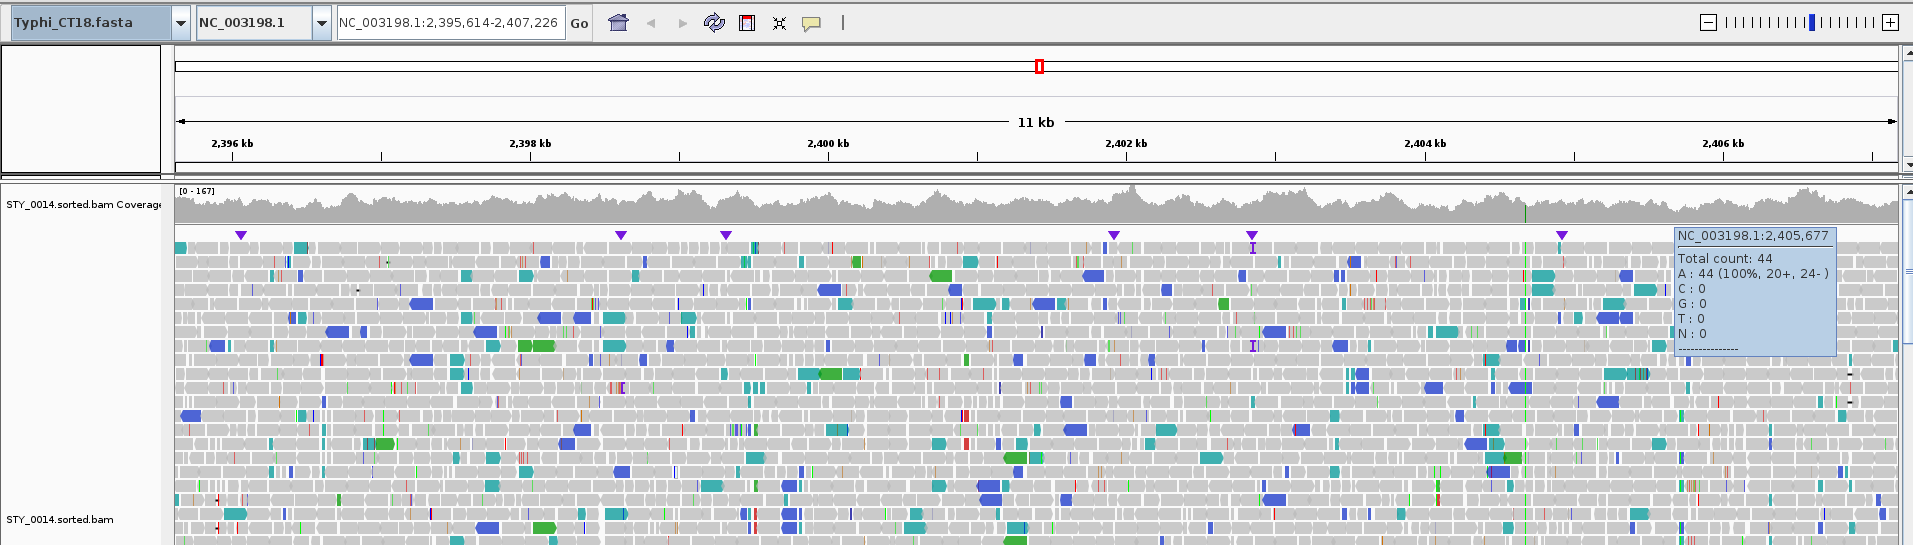

## Declare the Variables

#### Collect Reference Data

List of Accession Numbers:
- _Salmonella enterica_: `NC_004631.1`
- _Klebsiella pneumoniae_: `NC_016845.1`
- _Pseudomonas aeruginosa_: `NC_002516.2`

In [17]:
# Reference accession number.
ACC=NC_004631.1

# Create the directory for reference file.
mkdir -p refs

# The name of the reference.
REF=refs/${ACC}.fa

(bioinfo) 
(bioinfo) 
(bioinfo) 
(bioinfo) 
(bioinfo) 
(bioinfo) 
(bioinfo) 
(bioinfo) 


: 1

In [18]:
# Download the reference sequence from NCBI
efetch -db nuccore -format fasta -id $ACC | seqret -filter -sid $ACC > $REF

(bioinfo) 
(bioinfo) 


: 1

In [ ]:
# Shortcut to read names.
R1=data/STY_0014_R1.fastq.gz
R2=data/STY_0014_R2.fastq.gz


# Create and Define Intermediate output folder
mkdir -p other_outputs
OUT=other_outputs

# The resulting alignment file name
SAM=$OUT/STY_0014.sam
BAM=$OUT/STY_0014.sorted.bam

## Step-1: Index the Reference

```
# Index reference for the aligner.
bwa index refs/reference-sequence.fasta

# Index the reference genome for IGV
samtools faidx refs/reference-sequence.fasta
```

In [ ]:
# Index reference for the aligner.
bwa index $REF

# Index the reference genome for IGV
samtools faidx $REF

## Step-2: Perform Short Read Alignment

In [ ]:
# Short Read Alignment
bwa mem -t 14 $REF $R1 $R2 > $SAM

In [ ]:
head -30 $SAM > sam_part.tsv

#### SAM Format

##### __Column 1: Query Name (QNAME)__

In [ ]:
cat $SAM | cut -f 1 | head -8

##### __Column 2: FLAG__

In [ ]:
cat other_outputs/STY_0014.sam |cut -f 2 | head -10

In [ ]:
samtools flags 163

In [ ]:
samtools flags

__Let's consider an example__
- 1 means “red”,
- 2 means “blue”,
- 4 means “tall”,
- 8 means “short”,
- 16 means “fast”,
- 32 means “cheap”

__Decoding SAM flags__: https://broadinstitute.github.io/picard/explain-flags.html

##### __Column-5: MAPQ (Mapping Quality)__

- __Likelihood__ of the alignment being placed __incorrectly.__
- Same __phred__ quality score as in FASTQ
- P = 10^-(Q/10)
- Q = -10log10(P)

In [ ]:
cat $SAM |cut -f 5 | head -10

##### __Column-6: CIGAR (Compact Idiosyncratic Gapped Alignment Representation)__

In [ ]:
cat other_outputs/STY_0014.sam |cut -f 6 | head -10

It's a compact representation of the alignment of sequences that is used in various bioinformatics tools and standards, such as the Sequence Alignment/Map (SAM) format.  
In the CIGAR string, various letters are used to denote different types of alignment:

- M: alignment match (can be a sequence match or mismatch)
- I: insertion to the reference
- D: deletion from the reference
- N: skipped region from the reference
- S: soft clipping (clipped sequences present in the read, but not in alignment)
- H: hard clipping (clipped sequences are not present in the read)
- P: padding (silent deletion from padded reference)
- =: sequence match
- X: sequence mismatch


Each of these letters is preceded by a number, indicating how many times that particular operation occurs consecutively. For example, a CIGAR string of __10M2D3M__ indicates: 
- a match of 10 bases
- followed by a deletion of 2 bases from the reference
- and then another match of 3 bases.

### Step-2.1 Convert SAM file to sorted BAM

In [ ]:
samtools sort -@ 14 $SAM -o $BAM

In [ ]:
samtools flagstat other_outputs/STY_0014.sorted.bam

--------------

>> __Why Sorting??__

In [ ]:
# Convert BAM to SAM
samtools view $SAM > other_outputs/sorted.sam

In [ ]:
# Check the alignment position in sam file 
head -200 other_outputs/sorted.sam > other_outputs/sorted_sam.tsv

### Step-2.2 Index the BAM File

In [13]:
samtools index $BAM

(bioinfo) 


: 1

>> __Let's view our alignment on IGV__

Interpreting Color by Pair Orientation in __IGV__: https://software.broadinstitute.org/software/igv/interpreting_pair_orientations

### (Optional)Refine Alignment 

In [ ]:
# Filter unmapped reads
samtools view -f 4 -b $BAM > other_outputs/unmapped.bam
samtools view -c other_outputs/unmapped.bam

In [ ]:
# Filter unmapped reads
samtools view -f 4 -b $BAM > other_outputs/unmapped.bam
samtools view -c other_outputs/unmapped.bam

-------

**Align and generate a BAM file directly**

`bwa mem -t 14 $REF $R1 $r2 | samtools sort > $BAM`

--------

# Variant Calling

## Step-3: Call variants

In [ ]:
# Determine the genotype likelihoods for each base.
bcftools mpileup \
    -d 1000 \
    -Q 20 \
    -Ou -B \
    --threads 14 \
    -f $REF \
    $BAM \
    > other_outputs/genotypes.bcf

In [ ]:
# Call the variants with bcftools
bcftools call \
    --ploidy 1 -vc \
    --threads 14 -Ov \
    other_outputs/genotypes.bcf \
    > raw_variants.vcf

----------

### VCF File Format

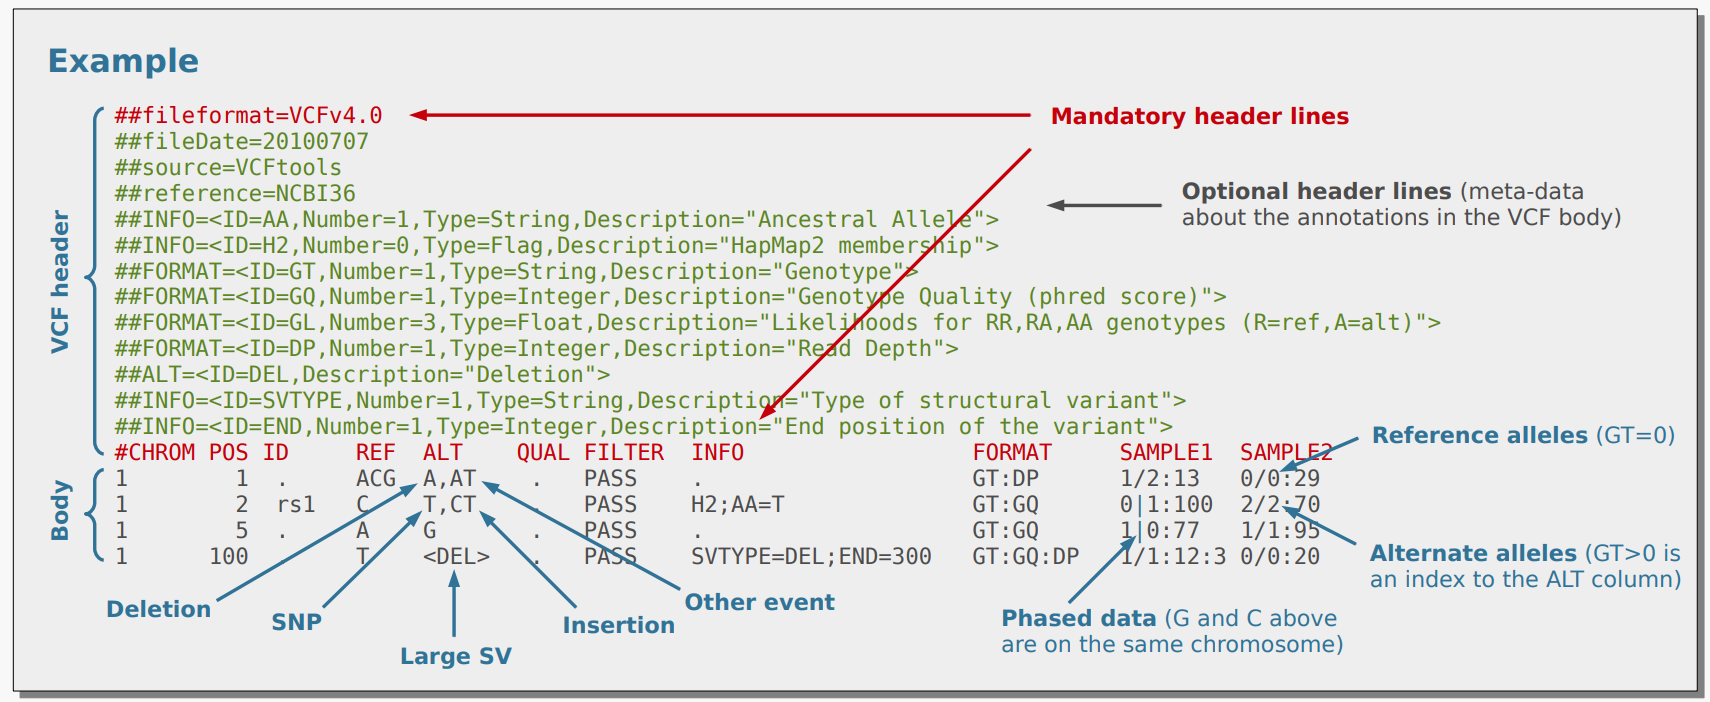

A VCF file is composed of two sections:
1. Header section
2. Record section 

#### VCF Header Section

- Contains the __specifications__ of various terms used throughout the file

```
##fileformat=VCFv4.1  
##contig=<ID=AF086833,length=18959>  
##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">  
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">  
```

For example: `AF = Allele Frequence`

#### `INFO` and `FORMAT` field

- `INFO`: describes a variant across all samples
- `FORMAT`: will have a different value for each sample

#### VCF Record Section

- Consists of at least __eight tab-delimited__ columns  
- The first eight columns __describe a variant__  
- The rest of the columns describe the properties of each sample  
- The __9th column is the FORMAT__ column  
- Each column passed the 9th will represent a sample

The first nine columns of a VCF file are:  
- `CHROM`: The chromosome (contig) on which the variant occurs  
- `POS`: The genomic coordinates on which the variant occurs. For deletions, the position given here are on of the bases preceding the event.  
- `ID`: An identifier for the variant (if it exists). Typically a dbSNP database if that is known.  
- `REF`: The reference allele on the forward strand.  
- `ALT`: The alternate allele(s) on the forward strand. More than one may be present.  
- `QUAL`: A probability that the __REF/ALT__ variant exists at this site. It is in the __Phred__ scale, just as the FASTQ quality and the MAPQ field in the SAM file are.  
- `FILTER`: The name of filters that the variant fails to pass, or the value PASS if the variant passed all filters. If the FILTER value is ., then no filtering has been applied to the record.  
- `INFO`: Contains the site-specific annotations represented as __ID=VALUE__ format.
- `FORMAT`: Sample-level annotations as colon-separated TAGS.

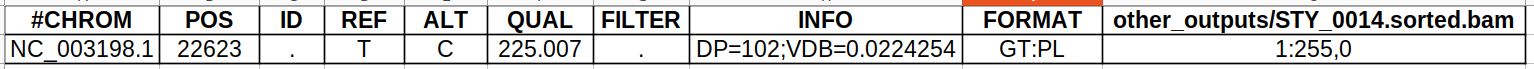

#### What is represented in the `REF/ALT` columns?  

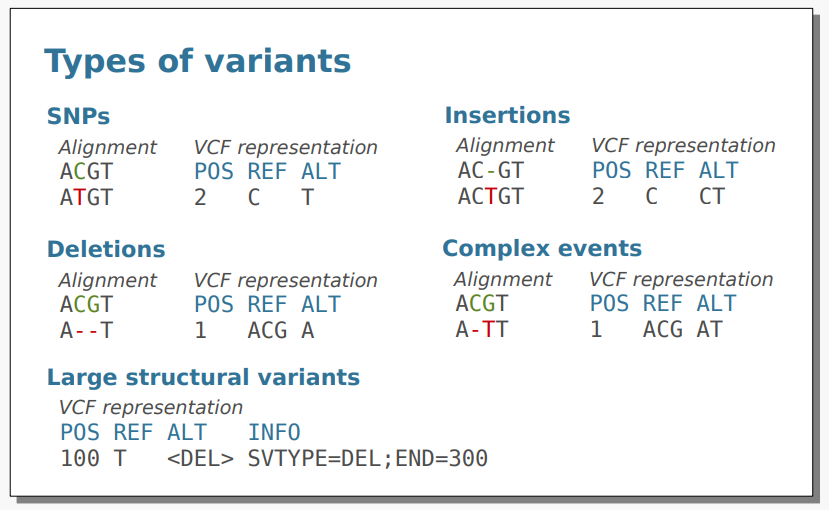

#### Interpret `FORMAT` field

Let's assume we have following `FORMAT`(9th), 10th and 11th field:

```
FORMAT         SAMPLE_1         SAMPLE_2
GT:PL         0/1:60,0,50    1/1:34,32,0  
```

Here,
- GT = Genotype 
- PL = List of Phred-scaled genotype likelihoods

##### __Interpret GT__

It is constructed out of slash-separated numbers where:  
- 0 indicates the REF field,  
- 1 indicates the first entry in the ALT field,  
- 2 indicates the second entry in the ALT field and so on. 

For example, for a __diploid__ organism, the GT field indicates the two alleles carried by the sample:  
- 0/0 - the sample is a homozygous reference  
- 0/1 - the sample is heterozygous, carrying one of each of the REF and ALT alleles  
- 1/2 - would indicate a heterozygous carrying one copy of each of the ALT alleles.  
- 1/1 - the sample is homozygous for the first alternate  
- 2/2 - the sample is homozygous for the second alternate

>> __Let's check the FORMAT field in our result!!!__

##### __Genotype Likelihoods (PL)__:
probabilities that describe the likelihood that each of the possible genotypes occurs.

For a __diploid__ organism `PL` field will contain three numbers, corresponding to the three possible genotypes (`0/0`, `0/1`, and `1/1`).   

The formula to calculate the likelihood: __10^(-phred_score/10)__

So, for the SAMPLE_1 the above example:  

- The Phred score for `0/0` is `60` means the chance of getting this genotype is `0.000001`  
- The Phred score for `0/1` is `0` means the chance for this genotype is `1`  
- The Phred score for `1/1` is `50` denotes a `0.00001` chance for this genotype  

--------

## Step-4: Filtering Information from VCF files

In [ ]:
# Filter SNPs 
bcftools view -v snps -g hom --threads 14 raw_variants.vcf > final_variants.vcf

In [ ]:
# Extract information in custom format
bcftools query -f '%CHROM %POS %REF %ALT\n' final_variants.vcf | head